# Hello, Julia!
> What I learnt and implemented 

- toc: true
- layout: post
- categories: [machine learning, maths]
- comments: true
- image: images/julia.jpg

Hey! This post is about my introduction to the world of Julia. I took this challenge of learning Julia and making something in it. Since Julia is pretty similar to Python, I made a hypothesis. That is can I learn julia and be up and running with something in two days? What I realised is, if you're from a python background and have some expereince in it, then learning Julia is going to be fun and breezy for you. So, here I am after my two day rendezvous with Julia.

So, what I used to learn Julia?
I used resources from [julia academy](https://juliaacademy.com/)

What did I implement?
I decided to go for one the resources I learnt deep learning from: [Neural Networks and Deep Learning](https://www.coursera.org/learn/neural-networks-deep-learning/home/welcome)

- Impemented the Julia version of [Week 2 assignment](https://www.coursera.org/learn/neural-networks-deep-learning/notebook/zAgPl/logistic-regression-with-a-neural-network-mindset) of [Neural Networks and Deep Learning](https://www.coursera.org/learn/neural-networks-deep-learning/home/welcome) course.

- It's not exactly that actually, I have applied the concepts to banknote authentication.
- Data is from UCI machine learning repository
- Training is done, inference is on the way!

I hope it's useful to you. It was a lot of fun and I am in love with Julia ❤

Let's begin!

In [1]:
using DelimitedFiles
using Random
using Plots

In [2]:
file = DelimitedFiles.readdlm("C:\\Users\\Abhishek Swain\\Desktop\\Julia_ML\\data_banknote_authentication.txt", ',');


See the first 5 rows of the given array

In [3]:
function head(file)
    file[1:5, 1:5]
end

head (generic function with 1 method)

In [4]:
head(file)

5×5 Array{Float64,2}:
 3.6216    8.6661  -2.8073  -0.44699  0.0
 4.5459    8.1674  -2.4586  -1.4621   0.0
 3.866    -2.6383   1.9242   0.10645  0.0
 3.4566    9.5228  -4.0112  -3.5944   0.0
 0.32924  -4.4552   4.5718  -0.9888   0.0

## Normalization

In [5]:
function normalize(file, num_cols)
    for i=1:num_cols
        file[:, i] /= sum(file[:, i])
    end
end

normalize (generic function with 1 method)

In [6]:
normalize(file, 4)

In [7]:
head(file)

5×5 Array{Float64,2}:
 0.00608586    0.00328576  -0.00146401   0.000273396  0.0
 0.00763908    0.00309668  -0.00128216   0.000894277  0.0
 0.00649655   -0.00100032   0.00100347  -6.51089e-5   0.0
 0.00580858    0.00361058  -0.00209184   0.00219847   0.0
 0.000553266  -0.0016892    0.0023842    0.000604788  0.0

## Splitting into train & test set
splits the data into train and test set

In [8]:
function train_test_split(file, at=0.7)
    n = size(file, 1)

    idx = shuffle(1:n)
    
    train_idx = view(idx, 1:floor(Int, at*n))
    test_idx = view(idx, (floor(Int, at*n)+1):n)
    
    file = convert(Matrix, file)
    return file[train_idx,:], file[test_idx,:]

end

train_test_split (generic function with 2 methods)

In [9]:
data_train, data_test = train_test_split(file);

X_train, y_train = data_train[:, 1:4], data_train[:, 5];

## **Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

## Sigmoid
Applies sigmoid to the vector

In [10]:
function σ(z) 
    """
    Compute the sigmoid of z
    """
    return one(z) / (one(z) + exp(-z))
end

σ (generic function with 1 method)

## Random initialization
Initialize `w` & `b` with with random values between (0, 1)

In [11]:
function initialize(dim)
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = zeros(dim, 1)
    b = 2
    
    @assert(size(w) == (dim, 1))
    @assert(isa(b, Float64) || isa(b, Int64))
    
    return w, b
end

initialize (generic function with 1 method)

## Notation

- According to our notation, `X` is of shape *(num_features, num_examples)*, in our case that is (4, 343). So, we need to reshape our `X`.
- `m` is the number of tranining examples.
- Similarly, `y` is a row vector or as Julia likes to call it `Array{Float64, 2}` of shape *(1, num_examples)*. 

In [12]:
X_train = reshape(X_train, (size(X_train, 2), size(X_train, 1)))
size(X_train)

(4, 960)

In [13]:
m = size(X_train, 2)

960

In [14]:
y_train = reshape(y_train, (1, size(y_train, 1)))

1×960 Array{Float64,2}:
 0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  …  1.0  0.0  0.0  1.0  0.0  1.0  1.0

In [15]:
cost = Array{Float64, 2}(undef, size(X_train, 2), 1);

## Forward and Backward propagation

`propagate` function is the function at the heart of the algorithm. This does the **forward prop -> calculate cost -> back-prop**.

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$


In [16]:
function propagate(w, b, X, Y)
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation
    """
    
    # Forward prop
    Z = w'X .+ b
    A = σ.(Z)
    @assert(size(A) == size(y_train))
    
    # Compute cost
    𝒥 = -1 * sum(y_train .* log.(A) .+ (1 .- y_train) .* log.(1 .- A))
    𝒥 /= m
    
    # Back-prop
    dz = A - Y
    @assert(size(dz) == size(A) && size(dz) == size(Y))
        
    dw = (1/m) * X * dz'
    db = (1/m) * sum(dz)
    
    𝒥, dw, db
end

propagate (generic function with 1 method)

In [17]:
w, b = initialize(size(X_train, 1))

([0.0; 0.0; 0.0; 0.0], 2)

## Model
Combine all functions to train the model
<br>
Learning rate: $\alpha = 0.09$, iterations(epochs): 150

Here is something I love about Julia. It's that you can directly use symbols as variables 😍. Doesn't it look awesome? 

In [18]:
α = 0.01

cost = Array{Float64, 2}(undef, 1500, 1)

for i=1:1500
    
    𝒥, dw, db = propagate(w, b, X_train, y_train)
    
    cost[i] = 𝒥
    
    global w, b
    
    w -= α * dw;  
    b -= α * db;
        
    println("cost after iteration $i: $𝒥")

end  

In [19]:
#hide

α = 0.01

cost = Array{Float64, 2}(undef, 1500, 1)

for i=1:1500
    
    𝒥, dw, db = propagate(w, b, X_train, y_train)
    
    cost[i] = 𝒥
    
    global w, b
    
    w -= α * dw;  
    b -= α * db;
        
    println("cost after iteration $i: $𝒥")

end    

cost after iteration 1: 1.237344677709639
cost after iteration 2: 1.2354446655104434
cost after iteration 3: 1.23354865094064
cost after iteration 4: 1.231656638820325
cost after iteration 5: 1.2297686339173424
cost after iteration 6: 1.227884640947018
cost after iteration 7: 1.226004664571897
cost after iteration 8: 1.2241287094014885
cost after iteration 9: 1.2222567799920088
cost after iteration 10: 1.2203888808461272
cost after iteration 11: 1.2185250164127168
cost after iteration 12: 1.2166651910866055
cost after iteration 13: 1.2148094092083326
cost after iteration 14: 1.212957675063903
cost after iteration 15: 1.2111099928845548
cost after iteration 16: 1.209266366846513
cost after iteration 17: 1.207426801070763
cost after iteration 18: 1.2055912996228177
cost after iteration 19: 1.2037598665124905
cost after iteration 20: 1.2019325056936647
cost after iteration 21: 1.200109221064079
cost after iteration 22: 1.1982900164651038
cost after iteration 23: 1.1964748956815285
cost af

cost after iteration 363: 0.8082712609105169
cost after iteration 364: 0.8077008240357535
cost after iteration 365: 0.8071328530595089
cost after iteration 366: 0.806567339465994
cost after iteration 367: 0.8060042747489053
cost after iteration 368: 0.8054436504116076
cost after iteration 369: 0.8048854579673133
cost after iteration 370: 0.8043296889392643
cost after iteration 371: 0.8037763348609092
cost after iteration 372: 0.8032253872760783
cost after iteration 373: 0.8026768377391573
cost after iteration 374: 0.8021306778152623
cost after iteration 375: 0.8015868990804079
cost after iteration 376: 0.8010454931216754
cost after iteration 377: 0.8005064515373825
cost after iteration 378: 0.7999697659372469
cost after iteration 379: 0.79943542794255
cost after iteration 380: 0.7989034291862985
cost after iteration 381: 0.7983737613133843
cost after iteration 382: 0.7978464159807435
cost after iteration 383: 0.797321384857512
cost after iteration 384: 0.7967986596251806
cost after ite

cost after iteration 592: 0.7268679242830831
cost after iteration 593: 0.7266710791796
cost after iteration 594: 0.7264751887502947
cost after iteration 595: 0.7262802485905299
cost after iteration 596: 0.7260862543134551
cost after iteration 597: 0.7258932015499601
cost after iteration 598: 0.7257010859486319
cost after iteration 599: 0.7255099031757078
cost after iteration 600: 0.7253196489150336
cost after iteration 601: 0.7251303188680148
cost after iteration 602: 0.7249419087535742
cost after iteration 603: 0.7247544143081052
cost after iteration 604: 0.7245678312854255
cost after iteration 605: 0.7243821554567319
cost after iteration 606: 0.7241973826105551
cost after iteration 607: 0.7240135085527112
cost after iteration 608: 0.7238305291062577
cost after iteration 609: 0.7236484401114465
cost after iteration 610: 0.7234672374256756
cost after iteration 611: 0.7232869169234447
cost after iteration 612: 0.7231074744963056
cost after iteration 613: 0.722928906052818
cost after ite

cost after iteration 871: 0.696944303223902
cost after iteration 872: 0.6968949054413077
cost after iteration 873: 0.6968457541174792
cost after iteration 874: 0.6967968480278881
cost after iteration 875: 0.6967481859539918
cost after iteration 876: 0.6966997666832067
cost after iteration 877: 0.6966515890088785
cost after iteration 878: 0.6966036517302554
cost after iteration 879: 0.6965559536524608
cost after iteration 880: 0.696508493586466
cost after iteration 881: 0.6964612703490621
cost after iteration 882: 0.6964142827628332
cost after iteration 883: 0.6963675296561287
cost after iteration 884: 0.6963210098630366
cost after iteration 885: 0.6962747222233576
cost after iteration 886: 0.6962286655825766
cost after iteration 887: 0.696182838791838
cost after iteration 888: 0.6961372407079155
cost after iteration 889: 0.6960918701931906
cost after iteration 890: 0.6960467261156226
cost after iteration 891: 0.6960018073487233
cost after iteration 892: 0.6959571127715319
cost after it

cost after iteration 1098: 0.6902264288405185
cost after iteration 1099: 0.6902105680748374
cost after iteration 1100: 0.6901947864380812
cost after iteration 1101: 0.6901790835345067
cost after iteration 1102: 0.6901634589703513
cost after iteration 1103: 0.6901479123538216
cost after iteration 1104: 0.6901324432950852
cost after iteration 1105: 0.6901170514062618
cost after iteration 1106: 0.690101736301411
cost after iteration 1107: 0.6900864975965239
cost after iteration 1108: 0.6900713349095138
cost after iteration 1109: 0.6900562478602065
cost after iteration 1110: 0.6900412360703301
cost after iteration 1111: 0.6900262991635064
cost after iteration 1112: 0.6900114367652407
cost after iteration 1113: 0.6899966485029135
cost after iteration 1114: 0.6899819340057693
cost after iteration 1115: 0.6899672929049092
cost after iteration 1116: 0.689952724833281
cost after iteration 1117: 0.6899382294256693
cost after iteration 1118: 0.6899238063186875
cost after iteration 1119: 0.6899094

cost after iteration 1456: 0.6875753850519817
cost after iteration 1457: 0.6875727260435006
cost after iteration 1458: 0.6875700802325252
cost after iteration 1459: 0.6875674475533825
cost after iteration 1460: 0.6875648279407274
cost after iteration 1461: 0.6875622213295415
cost after iteration 1462: 0.6875596276551303
cost after iteration 1463: 0.6875570468531238
cost after iteration 1464: 0.6875544788594721
cost after iteration 1465: 0.687551923610444
cost after iteration 1466: 0.6875493810426289
cost after iteration 1467: 0.6875468510929312
cost after iteration 1468: 0.6875443336985702
cost after iteration 1469: 0.6875418287970791
cost after iteration 1470: 0.6875393363263028
cost after iteration 1471: 0.6875368562243962
cost after iteration 1472: 0.687534388429823
cost after iteration 1473: 0.6875319328813542
cost after iteration 1474: 0.687529489518066
cost after iteration 1475: 0.6875270582793392
cost after iteration 1476: 0.6875246391048566
cost after iteration 1477: 0.68752223

## Plotting 
For plotting we use the `Plots` package.

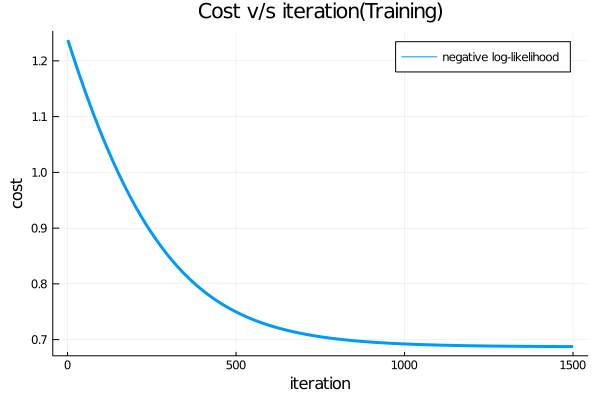

In [20]:
x = 1:1500;
y = cost;

gr() # backend

plot(x, y, title = "Cost v/s iteration(Training)", label="negative log-likelihood", lw=3)
xlabel!("iteration")
ylabel!("cost")

In [21]:
function predict(w, b, X)
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    """
    
    m = size(X, 1)
    Y_pred = zeros(1, m)
    X = reshape(X, (size(X, 2), size(X, 1)))
    
    A = σ.(w'X .+ b)
    
    for i=1:size(A, 2)
        
        if(A[i] > 0.5)
            Y_pred[i] = 1
        else
            Y_pred[i] = 0
        end
    end
    
    @assert(size(Y_pred) == (1, m))
        
    Y_pred
    
end

predict (generic function with 1 method)

In [22]:
X_test, y_test = data_test[:, 1:4], data_test[:, 5];

In [23]:
preds = predict(w, b, X_test)

1×412 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [24]:
y_test = reshape(y_test, (1, 412))

1×412 Array{Float64,2}:
 0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  …  0.0  0.0  1.0  1.0  1.0  0.0  0.0

In [25]:
cnt = 0

for i=1:size(y_test, 2)
    
    if(y_test[i] == preds[i])
        cnt +=  1
    end
end

In [26]:
acc = (cnt/size(y_test, 2)) * 100;

In [27]:
println("Accuracy: $acc")

Accuracy: 55.582524271844655


## Epilouge

You can see accuracy is really just 56% which is what to say 🤣🤣, but then I have not done any preprocessing except normalization & then there are also things we can do to optimize, like handling class-imbalance etc.

![](my_icons/Honest_Work.jpg)

The goal was to implement Logistic regression with back-prop from scratch which I did. Hope you will take something from it.

## Github repo for notebook: [Julia_ML](https://github.com/Abhiswain97/Julia_ML)

As always, thank you for reading 😊😃!